# Lab 13 (Module 12)
## Tree Models
4/25/2018

### Announcements:
* Reminder: Problem Set due April 25th today, late submissions accepted only until May 1. 
* Next week will be a review session.  I'll plan to do an additional recorded review session the day before the exam during office hours time-- 1pm-3pm.


### Plan for Today's Lab
1. Simple Classification Trees + R example (10 min)
2. Random Forest + R example (10 min)
3. Boosting + R example (10 min)

## 1-Simple Classification Trees
To illustrate the process of building a classification tree, we will consider the case where we have a binary outcome with two predictor varables X1 and X2.
Roughly speaking, there are two steps.
1. We divide the  set of possible values for X1 and X2 J distinct and non-overlapping regions, R1, R2,...,RJ .
2. For every observation that falls into a given region, we make the same prediction, which is 1 if more than 50% of the outcome values for the training observations in that region are equal to 1, and 0 otherwise.

The goal is choose regions of X1 and X2 that minimize the number of incorrect predictions (1 when true value is 0, or 0 when true value is 1). Unfortunately, it is computationally infeasible to consider every possible partition of our predictor variables.  

For this reason, we take a top-down, greedy approach that is known as recursive binary splitting. This means that we consider X1 and X2 and all possible "cuts" of each variable. If our variables were age and gender, gender would have one cutpoint, and age would have a number of cutpoints equal to the number of ages in the dataset. Then we pick the variable and cutpoint such that the resulting tree of two branches has the lowest number of incorrect predictions.

Next, we repeat the process, looking for the best predictor and cutpoint in order to split the data further so as to minimize the number of incorrect predictions in each of the resulting regions. However, this time, we split one of the two previously identified regions to get 3 regions. The process continues until a stopping criterion is reached; for instance, we may continue until no region contains more than five observations.

The process described above may produce good predictions on the training set, but is likely to overfit the data, leading to poor test set performance. We can "prune" the tree to prevent this issue.  See ISL for further details on pruning.

We'll illustrate in R this with a dataset where observations are passengers on the Titanic.  The dataset contains variables that give some information about each passenger such as class, gender, age and whether they survived the shipwreck.  First, we'll load relevant dataset and packages.  We'll also create a test and training dataset.

### search "Titanic ML"

In [2]:
# set working directory
# setwd("/home/jovyan/mba217-2/Data")

# Clear Environment 
rm(list = ls())
# Clear Console
cat('\014')

#install required packages
#install.packages(c("randomForest","party", "gbm"))
# Load required packages
require(dplyr)
# require(ggplot2)
# For the tree functions
require(rpart) # rpart()
require(party)
# For Random Forest
require(randomForest) # randomForest()
# For Boosting
require(gbm)


Loading required package: party
Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich
Loading required package: gbm
Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.3


In [3]:
# Read the data and remove observations with missing data
Titanic <- read.csv("../Data/Titanic.csv", header = TRUE)
# remove obs with missing data, and select a few predictors
Titanic <- na.omit(Titanic[,c("survived","pclass","sex","age","sibsp")])
attach(Titanic)
names(Titanic)
dim(Titanic)

# for reproducibility
set.seed(1234)

# create train and test sets (~40% for training, ~60% for testing)
Titanic$randu <- runif(nrow(Titanic),0,1)
Titanic.train <- Titanic[Titanic$randu < .4,]
Titanic.test <- Titanic[Titanic$randu >= .4,]

[1] "survived" "pclass"   "sex"      "age"      "sibsp"

[1] 1046    5

Now we use the function rpart to create a simple tree using only the age and class variables.  This automatically performs the recursive binary splitting process for us.  Below, we see that it makes the correct prediction about 65% of the time in the test dataset.  CP=0.05 is the pruning parameter.  Typically we'd use cross validation to select the optimal pruning parameter, but we're keeping it simple here and just picking one.

In [4]:
# Simple classification tree using rpart on training data
simp.tree <- rpart(as.factor(survived) ~ pclass + age, data = Titanic.train, method="class", cp=.05)
# Fit model to test data and calculate MSE, which is just % incorrect predictions
Titanic.test$pred<-predict(simp.tree, Titanic.test, type = c( "class"))
Titanic.test$pred<-ifelse(Titanic.test$pred=="1", 1, 0)
mean((Titanic.test$pred-Titanic.test$survived)^2)

[1] 0.3496063

Next, we can fit the model to the full dataset and generate a picture of the actual tree.  For the condition at each node, TRUE goes to the left, and FALSE to the right.  The 0 or 1 at the bottom of the node is the prediction for that node, and the number below that is Survive=0/Survive=1.

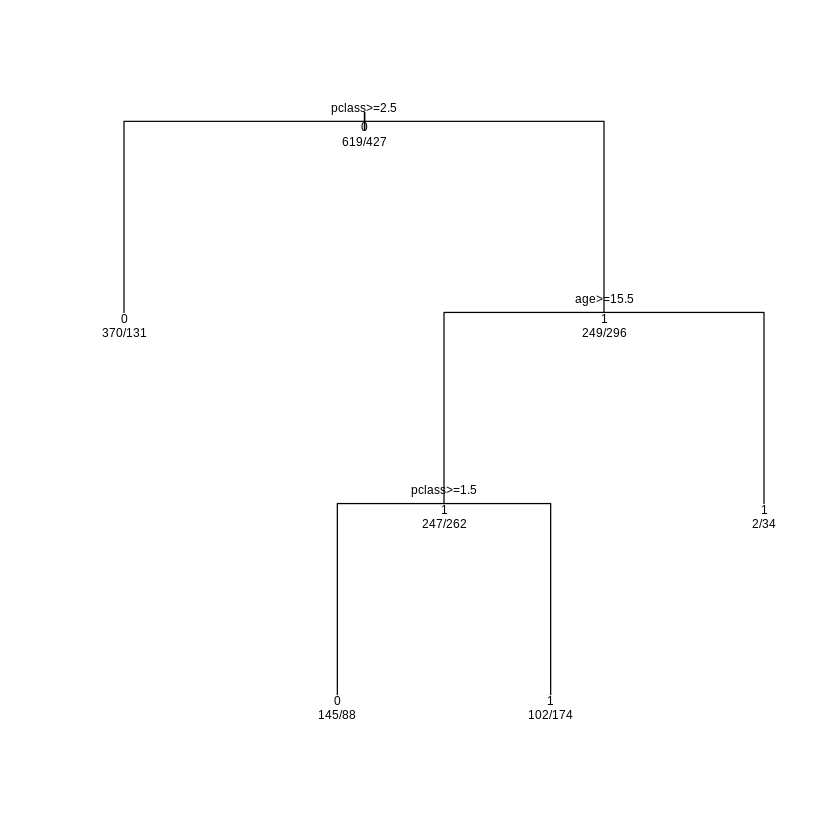

In [5]:
# plot model on full dataset
simp.tree.full <- rpart(as.factor(survived) ~ pclass + age, data = Titanic, method="class", cp=.05)
plot(simp.tree.full, uniform = TRUE) # plot tree
text(simp.tree.full, use.n = TRUE, all = TRUE, cex = 0.6, main = "Titanic") # add labels to tree

## 2-Random Forest
Random forests is a technique that uses multiple trees.  A typical procedure uses the following steps:
 1. Choose a bootstrap sample of the observations and start to grow a tree.
 2. At each node of the tree, choose a random sample of the predictors to make the next decision. Do not prune the trees.
 3. Repeat this process many times to grow a forest of trees.
 4. In order to determine the classification of a new observation, have each tree make a classification and use a majority vote for the final prediction.
 
We'll illustrate this below using the titanic dataset again.  R fits a random forest using a single command.  We'll calculate the error rate again, this time using the confusion matrix.

In [15]:
#### Random Forests #####
# It is important to set seed to for replicating results as there's a lot of randomization that happens in Random Forests
set.seed(1234)

#Fit the training data
# nodesize is minimum size of terminal nodes
# mtry is number of variables randomly sampled as candidates at each split
# ntree is the number of bootstrap samples
model.rf <- randomForest(as.factor(survived) ~ pclass + sex + age + sibsp,
                         data = Titanic.train, mtry = 2, nodesize = 30, ntree = 500)
#predict outcomes on the test data
pred.rf <- predict(model.rf, newdata = Titanic.test)
#compare actual and predicted outcomes
conf.rf <- table(pred.rf, Titanic.test$survived)
conf.rf
#calculate the error rate
(conf.rf[1,2]+conf.rf[2,1])/sum(conf.rf)
# or equivalent to 
mean(pred.rf != Titanic.test$survived)
#total decrease in node impurities from splitting on the variable, averaged over all trees
importance(model.rf)

       
pred.rf   0   1
      0 335  82
      1  44 174

[1] 0.1984252

[1] 0.1984252

,MeanDecreaseGini
pclass,23.184489
sex,45.836664
age,15.945779
sibsp,6.797071


## 3-Boosting
Boosting involves repeated estimation where misclassified observations are given increasing weight in each repetition. The final estimate is then a vote or an average estimate across the repeated estimates.  

First, an initial tree is fit.  Given that model, we fit a decision tree to the residuals. That is, we fit a tree using R= (1= misclassified positive, -1=misclassified negative), rather than the outcome Y , as the response. We then add this new decision tree into the fitted function in order to update the residuals. 

Boosting has three tuning parameters:
1. The number of trees B. Unlike bagging and random forests, boosting can overfit if B is too large, although this overfitting tends to occur slowly if at all. We use cross-validation to select B.
2. The shrinkage parameter λ, a small positive number. This controls the rate at which boosting learns. Typical values are 0.01 or 0.001, and the right choice can depend on the problem. Very small λ can require using a very large value of B in order to achieve good performance.
3. The number d of splits in each tree or the "interaction depth", controls the interaction order of the boosted model, since d splits can involve at most d variables.  Typically 1 or 2 is a good choice, and we can compare using the test error rate.

In [10]:
### Boosting #####
model.boost <- gbm(survived ~ pclass + sex + age + sibsp,
                 data = Titanic.train,
                 distribution = "bernoulli",
                 n.trees = 10000,
                 shrinkage = 0.001,
                 interaction.depth = 1)

pred.boost <- predict(model.boost, newdata = Titanic.test, type ="response", n.trees=1000)
pred.boost <- ifelse(pred.boost >=0.5 , 1, 0)
conf.boost <- table(pred.boost, Titanic.test$survived)
conf.boost
(conf.boost[1,2]+conf.boost[2,1])/sum(conf.boost)
# or
mean(pred.boost != Titanic.test$survived)

          
pred.boost   0   1
         0 324  78
         1  55 178

[1] 0.2094488

[1] 0.2094488